In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import stats
import sklearn
# import statsmodels.formula.api as sm
import statsmodels.api as sm

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_absolute_error, make_scorer, mean_squared_error

from sklearn.linear_model import LinearRegression, Lasso, Ridge, RANSACRegressor, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR, LinearSVR, OneClassSVM
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor
from mlxtend.evaluate import bias_variance_decomp


In [4]:
print(sklearn.__version__)

0.23.2


In [3]:
%run functions.ipynb

In [4]:
plt.style.use('seaborn')

# ПРОЕКТ ЗА СЪЗДАВАНЕ НА МОДЕЛИ ЗА ПРЕДСКАЗВАНЕ НА ЦЕНИ НА НЕДВИЖИМИ ИМОТИ - ЕДНОФАМИЛНИ ЖИЛИЩА

Оценката на цените на жилищата е важно финансово решение за всички участници на пазара на жилища - предприемачи, брокери, оценители, финансови институции и потенциални купувачи. Независимо от ролята на всеки един в процесите, които протичат, всеки един субект се интересува от потенциалната печалба, от пазарната стойност на обекта, който придобива или печалбата, която може да реализира.<br> 
По дефиниция,  в ЕВРОПЕЙСКИТЕ СТАНДАРТИ ЗА ОЦЕНЯВАНЕ (EСО) - 2020 г., определението за „Пазарна стойност” е: „Оценената сума, срещу която даден актив или пасив може да смени собственика си към датата на оценката чрез сделка между независими един от друг, желаещ купувач и желаещ продавач, след подходящ маркетинг, при което всяка от страните е действала информирано, благоразумно и без принуда”.<br>
В този проект ще разгледаме възможни алгоритми за машинно обучение, с цел да бъде разработена система за прогнозиране на цени на жилищата, а не на тяхната пазарната стойност.<br>
Изследването се състои от четири етапа, а именно:
* четене на предварително събрани данни, запълване на липсващи стойности, обработка на независимите променливи, анализ и трансформация във формат, подходящ да бъдат приложени в тренирането на модели за машинно обучение.
* разработка на модели за машинно обучение
* валидиране и тестване на моделите
* сравнение, анализ и избор на най-успешния модел

ХИПОТЕЗА<br>
Опитът в оценяването на недвижими имоти, показва, че стойността, на която се извършват сделките, често е повлияна от субективни фактори, както и явления на пазара, които могат да останат скрити. В резултат на това,  се приема за нормално становището на независим оценител за пазарната стойност на обект, да се различава от стойността на реализацията му.<br> Стартираме проекта, при допускането, че данните с които ще работим са "замърсени" от явления и решения, които не могат да бъдат обективно измерени и описани, както и че целта е предвиждане на евентуална цена на реализация, а не извеждане на пазарна стойност на обектите. <br> 
Негласно, в пактиката на оценяването, се допуска, че в изведената пазарна стойност за един и същи имот, на двама независимо работещи един от друг оценители или от стойността на сделката, може да има отклонение в размер на от 5-7%. 
На тази база, изследванията в настоящият проект ще бъдат използвани, за да се разгледат два въпроса в предвиждането на цени на недвижими имоти.<br> 
1. Предвиждане на цена на пакет/портфейл от недвижими имоти.<br>
Може ли да бъде обучен модел, който да предвиди цената на портфейл от имоти. Приема се, че това е така, ако процентът на остатъците /residuals/ за целият сет е по-малко или равно на 5% от тестовият сет.
2. Предвиждане на цена на един самостоятелен недвижим имот.<br> 
Може ли да бъде обучен модел, който да предвижда цената на един единствен имот. Приема се, че това е така, ако  процентът на всеки еднин остатък /residual/ е по-малко или равно на 5%.<br>

За целите на настоящия проект се използват данни от https://www.kaggle.com/c/house-prices-advanced-regression-techniques

### 1. Прочитане и запознаване с данните

In [5]:
train = pd.read_csv('train.csv')
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
train.shape

(1460, 81)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### 2. Почистване на данните и попълване на липсващи стойности

Премахваме излишната колона с индекси и поради високите стойности на продажните цени, да ги преобразуваме в стойност в хил USD.

In [8]:
train = train.drop('Id', axis=1)

In [9]:
train.shape

(1460, 80)

In [10]:
train.SalePrice = train.SalePrice.divide(other=1000)

От описанието на сета се вижда, че в част от променливите има липсващи стойности. Престъпваме към анализът им и запълването им.

In [11]:
missing_values = train.isnull().sum()
missing_values[missing_values>0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

* Има 19 категории в данните, вкоито има липсващи стойности.<br>
* Нечислови променливи - Alley, MasVnrType, BsmtQual, BsmtCond, BsmtExposure,   BsmtFinType1, BsmtFinType2, Electrical, FireplaceQu,  GarageType,   GarageFinish, GarageQual, GarageCond, PoolQC, Fence, MiscFeature - След обследване на променливите се вижда, че липсващите стойности в нечисловите променливи са всъщност клас, който показва отсъствието на комфорт факторът и затова същата се заменя с  "Not available".<br>
* Числови променливи  LotFrontage, MasVnrArea, GarageYrBlt се запълват със средната стойност за категорията. 

In [12]:
# Запълвам всички нечислови липсващи стойности с "not available"
for col in train.select_dtypes(exclude = ['int64', 'float64']): 
    train[col].fillna('Not available', inplace= True)

In [13]:
# Числовите променливи LotFrontage, MasVnrArea, GarageYrBlt, запълваме със средната за променливата стойност.
train['LotFrontage'].fillna(train['LotFrontage'].mean(), inplace=True)
train['MasVnrArea'].fillna(train['MasVnrArea'].mean(), inplace=True)
train['GarageYrBlt'].fillna(train['GarageYrBlt'].mean(), inplace=True)

In [14]:
# Правим проверка дали стойностите са запълнени.
train.isna().sum().sum()

0

In [15]:
# Присвояваме към променливи числовите и нечисловите колони
categorical_columns = train.select_dtypes(include=['object'])
numerical_columns = train.select_dtypes(exclude=['object'])

In [16]:
len(categorical_columns.columns), len(numerical_columns.columns), len(train.columns)

(43, 37, 80)

### Анализ на числовите променливи

In [17]:
numerical_columns.describe().T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1460.0,56.897260,42.300571,20.0,20.000,50.000000,70.00,190.0
LotFrontage,1460.0,70.049958,22.024023,21.0,60.000,70.049958,79.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.500,9478.500000,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.000,6.000000,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.000,5.000000,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.000,1973.000000,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.000,1994.000000,2004.00,2010.0
MasVnrArea,1460.0,103.685262,180.569112,0.0,0.000,0.000000,164.25,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.000,383.500000,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.000,0.000000,0.00,1474.0


In [18]:
numerical_features_correlation = train.corr()
numerical_features_correlation.sort_values(["SalePrice"], ascending = False, inplace=True)
# numerical_features_correlation.SalePrice.head(30)

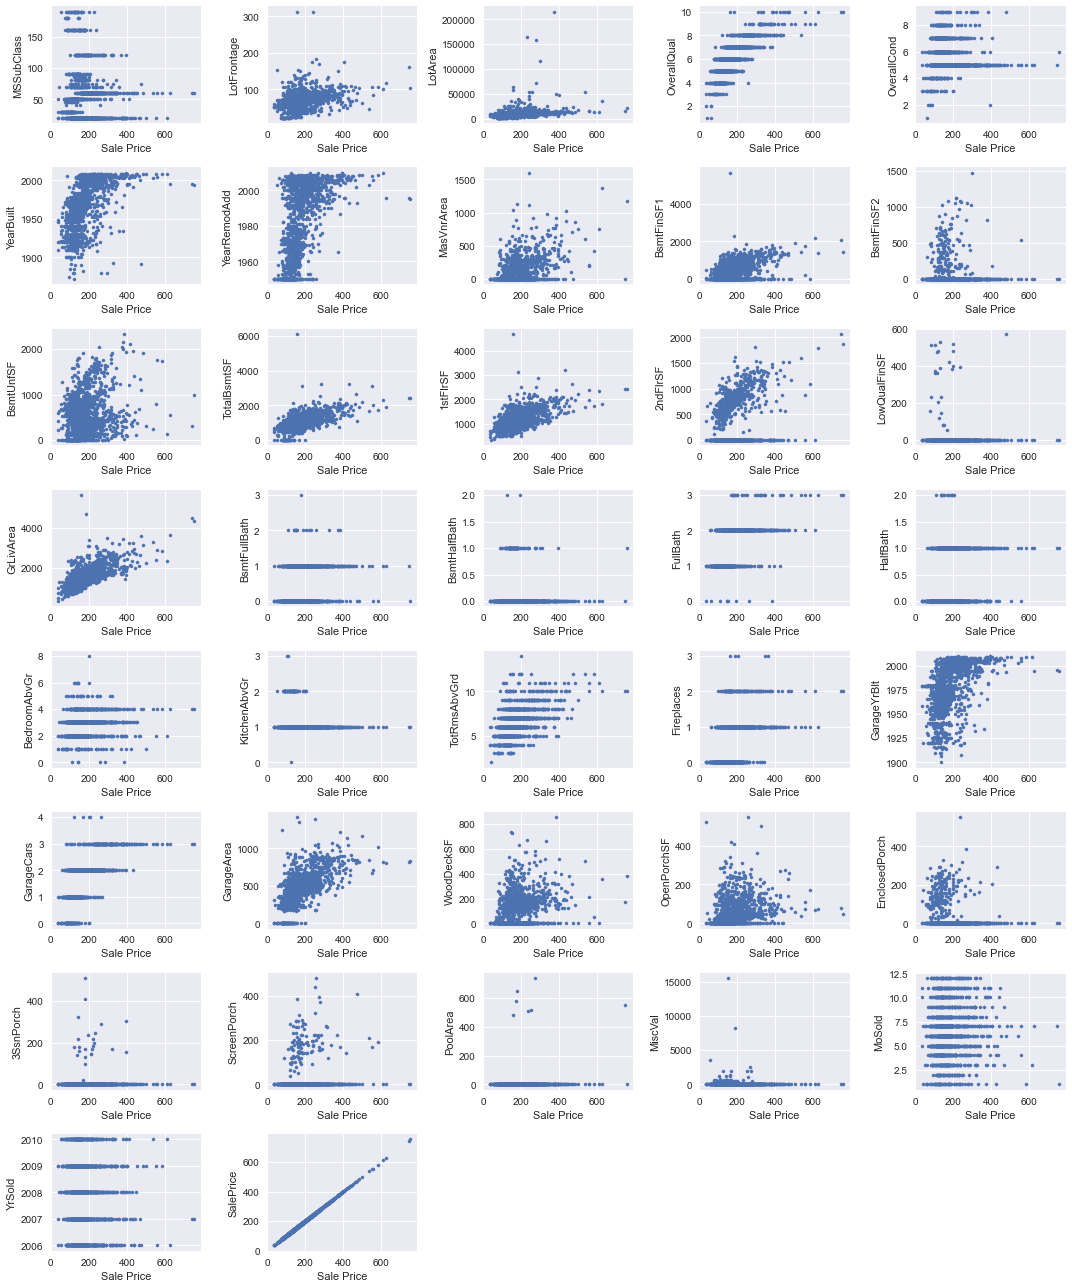

In [19]:
plt.figure(figsize=(15, 18))

i = 1
for col in numerical_columns:
    plt.subplot(8,5,i)
    plt.scatter(train.SalePrice, train[col], s=10)
    plt.xlabel('Sale Price')
    plt.ylabel(col)
    i +=1
    
plt.tight_layout()
plt.show()

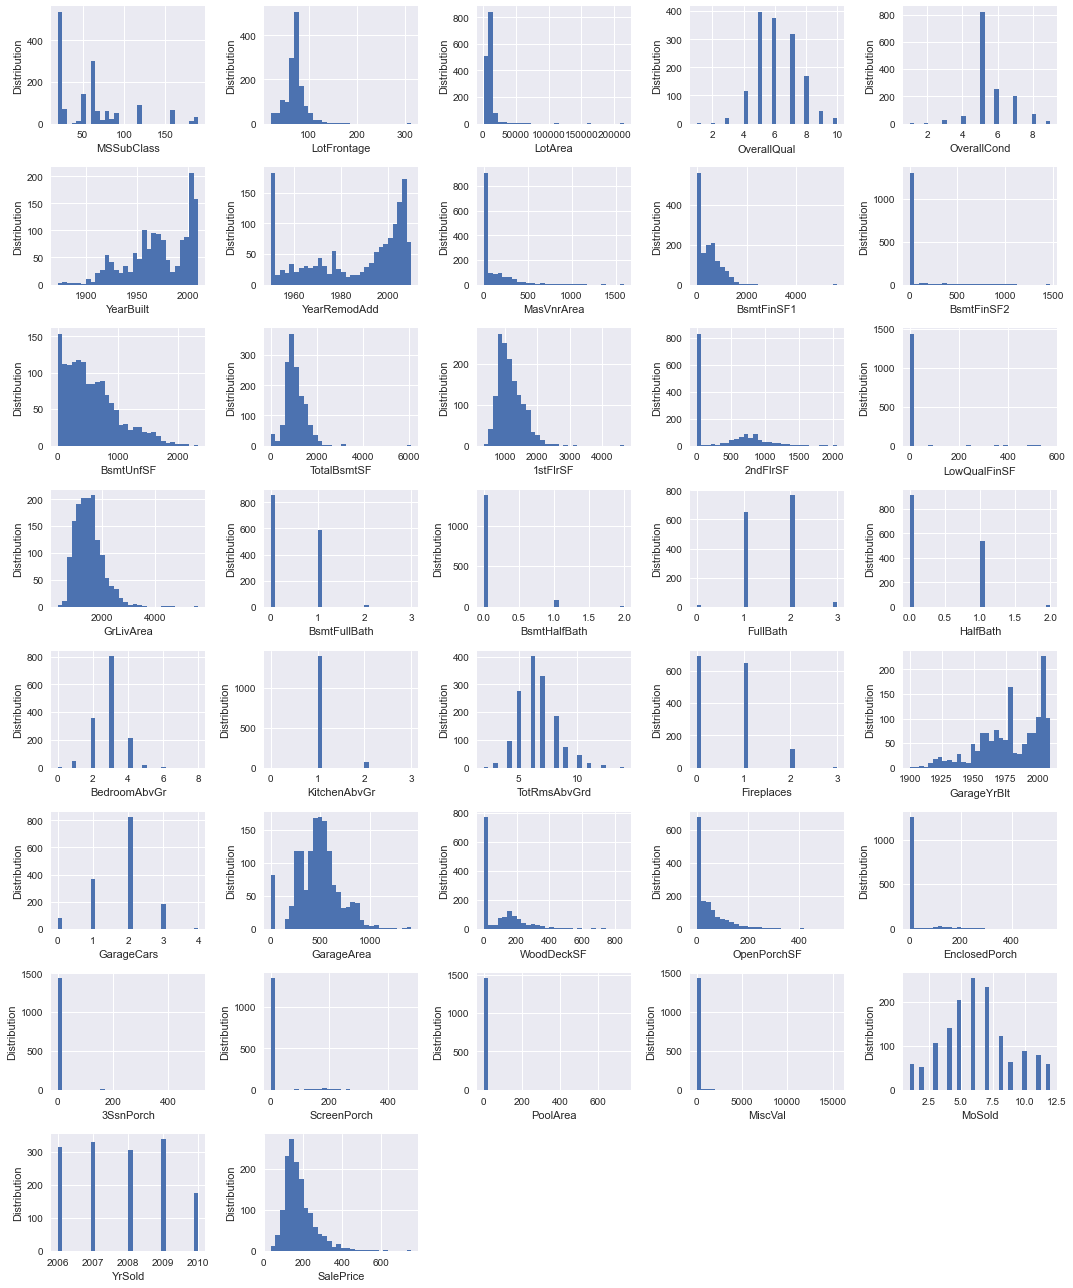

In [20]:
plt.figure(figsize=(15, 18))

i = 1
for col in numerical_columns:
    plt.subplot(8,5,i)
    plt.hist(train[col], bins=30)
    plt.xlabel(col)
    plt.ylabel('Distribution')
    i +=1
    
plt.tight_layout()
plt.show()

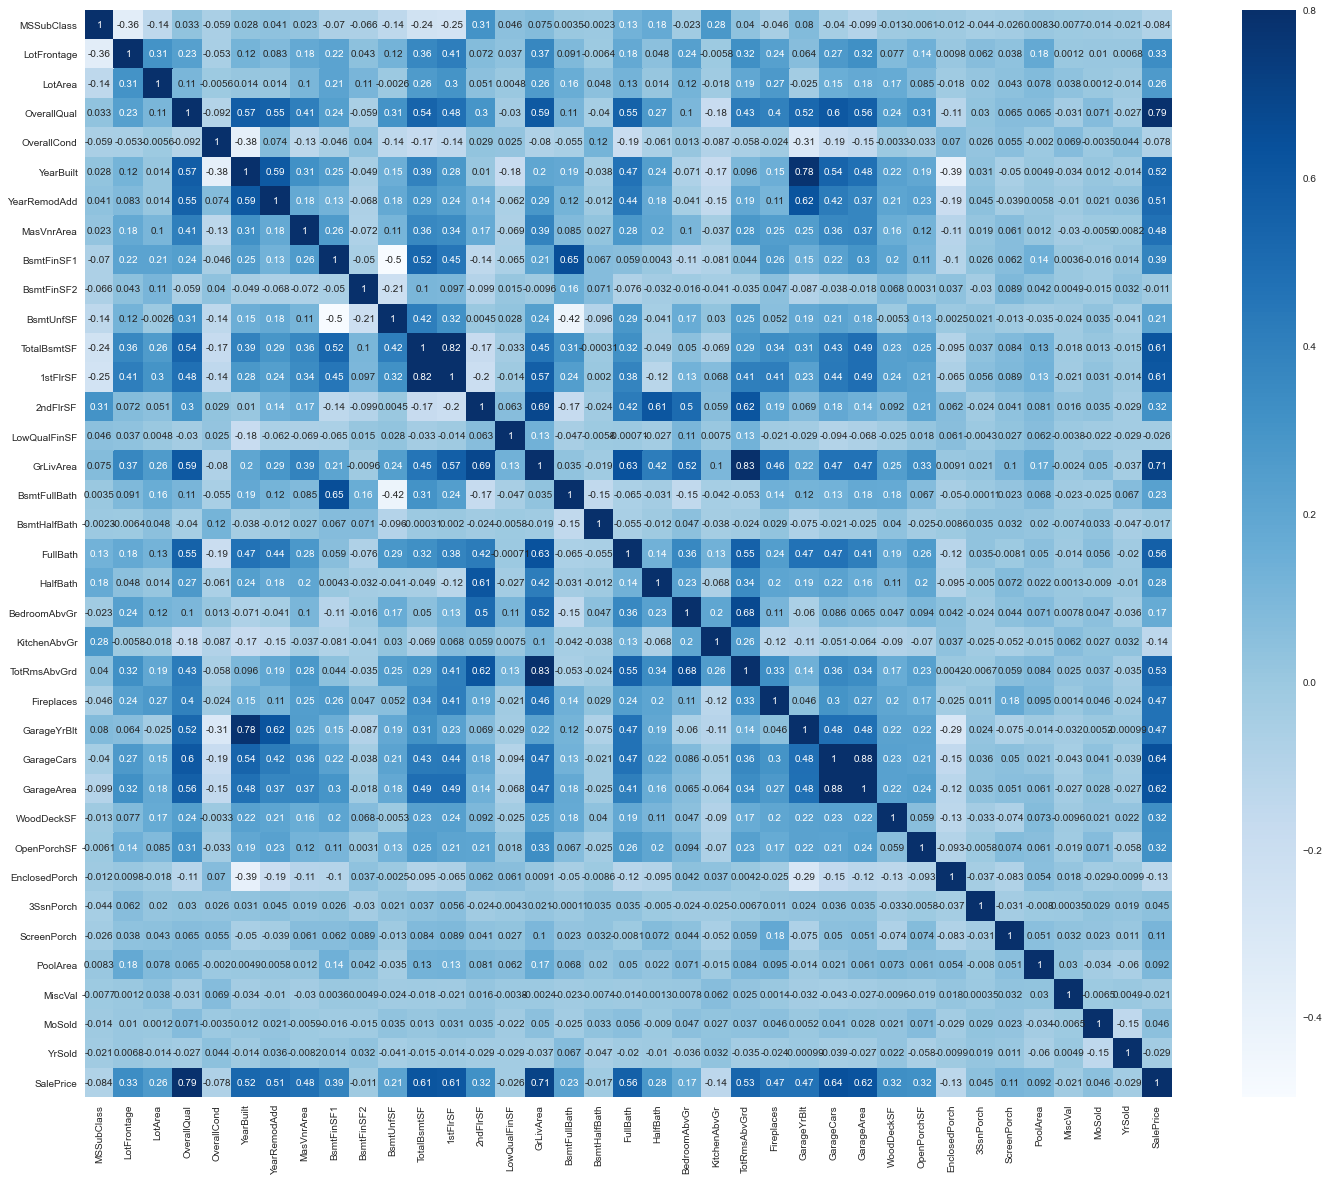

In [21]:
corr_mat = train.corr()
k = len(train.columns)
cols = corr_mat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values)
f, ax = plt.subplots(figsize=(25, 20))

sns.heatmap(corr_mat, vmax=.8, square=True, annot = True, cmap = 'Blues')
plt.show()

#### Фючър селекшън на цифровите променливи

Премахваме променливите, които са с корелация м/у -0,05 и 0,05 и които на практика почи не оказват влияние върху стойността.

In [22]:
low_price_corr_columns = corr_mat['SalePrice'][abs(corr_mat['SalePrice'].values) < 0.05].index.values
low_price_corr_columns

array(['BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', '3SsnPorch',
       'MiscVal', 'MoSold', 'YrSold'], dtype=object)

In [23]:
train = train.drop(list(low_price_corr_columns), axis=1)

Площта на гаража и броят коли, за които е предназначен са напрактика препокриващи се променливи, силно зависими една от друга. Премахваме площтта, която е смалко по-ниска корелация.

In [24]:
train = train.drop('GarageArea', axis=1)
train = train.drop('GarageYrBlt', axis=1)

Махаме променливата за площ на втори етаж. Има колони с цялата площ и с площта на първия етаж, а площщта на втория етаж е разлика от двете. В същата променлива има много нулеви стойности, тъй като голяма част от сградите са едноетажни.

In [25]:
train = train.drop(['2ndFlrSF'], axis=1)
train = train.drop('1stFlrSF', axis=1)

Премахваме променливата за незавършен сутерен, тъй като имаме площ на целия сутерен и стойност на завършената част от него.

In [26]:
train = train.drop('BsmtUnfSF', axis=1)
train = train.drop('BsmtFinSF1', axis=1)

In [27]:
train = train.drop('TotRmsAbvGrd', axis=1)

Променливата PoolQC има 1453 липсващи стойности от общо 1460 записа, поради което приемаме, че тя не носи стойност към цената.

In [28]:
train = train.drop('PoolQC', axis=1)

#### Анализ на категорийните променливи

In [30]:
# Превръщам цифровите променливи, които по смисълът си трябва да са категорийни, също преобразувам в такива.
train.MSSubClass = train.MSSubClass.astype('object')

In [31]:
# презаписвам променливата след направената корекция
categorical_columns = train.select_dtypes(include=['object'])

In [32]:
categorical_description_df = categorical_columns.describe().T
categorical_description_df

,count,unique,top,freq
MSSubClass,1460,15,20,536
MSZoning,1460,5,RL,1151
Street,1460,2,Pave,1454
Alley,1460,3,Not available,1369
LotShape,1460,4,Reg,925
LandContour,1460,4,Lvl,1311
Utilities,1460,2,AllPub,1459
LotConfig,1460,5,Inside,1052
LandSlope,1460,3,Gtl,1382
Neighborhood,1460,25,NAmes,225


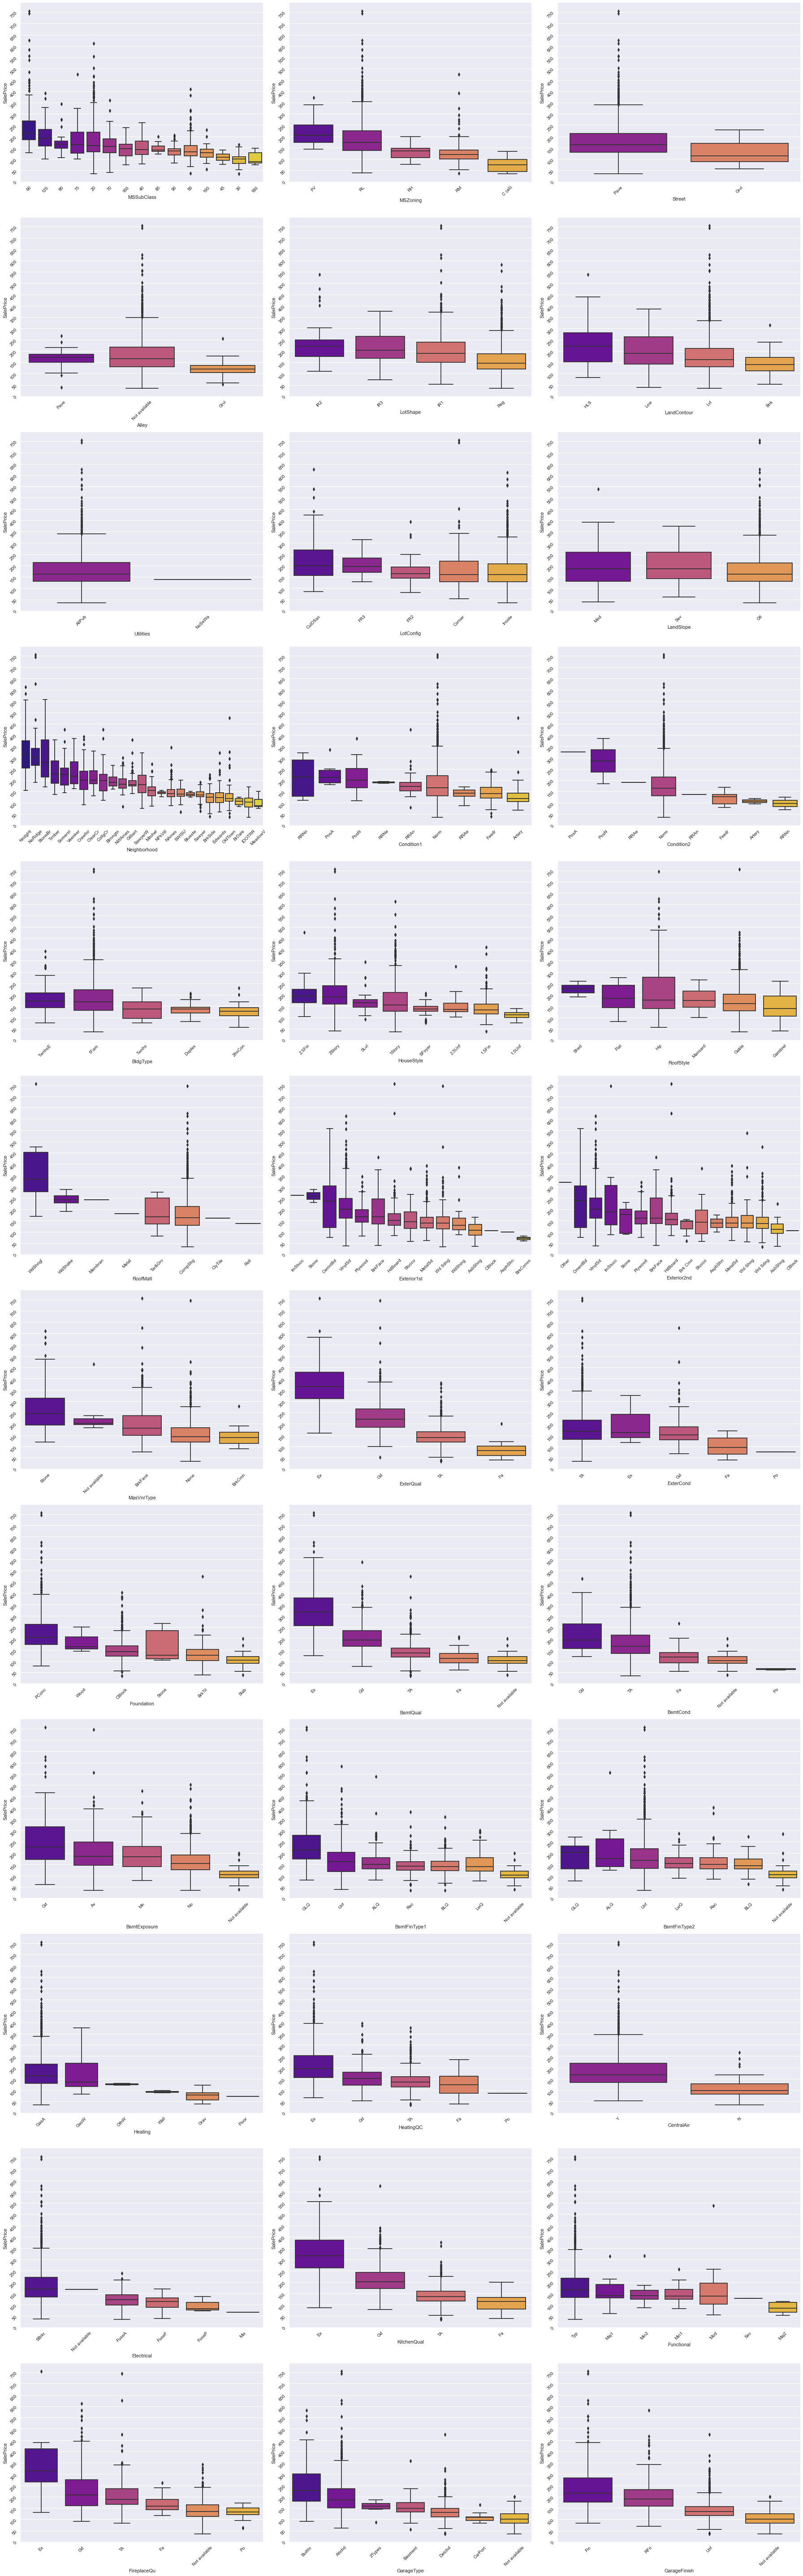

In [33]:
def srt_box(y, df):
    fig, axes = plt.subplots(12, 3, figsize=(25, 80))
    axes = axes.flatten()

    for i, j in zip(train[[col for col in train.select_dtypes(include=['object'])]], axes):

        sortd = df.groupby([i])[y].median().sort_values(ascending=False)
        sns.boxplot(x=i,
                    y=y,
                    data=df,
                    palette='plasma',
                    order=sortd.index,
                    ax=j)
        j.tick_params(labelrotation=45)
        j.yaxis.set_major_locator(ticker.MaxNLocator(nbins=18))

        plt.tight_layout()
     

srt_box('SalePrice', train)

От диаграмите може да се направи извод, че има голямо нетипични стойности при категорийните променливи. Прави впечатление, че те често принадлежат към един или два класа от съответната категория, най-често в посока нагоре, което може да означава, че категорията не едобре разделена на класове или че променливата е излишна като цяло, тъй като в една категория попадат почти всички записи и има нужда от задълбочен анализ, който да създаде подредени или неподредени стойности, които правилно да описват обектите на оценка.

#### Фючър селекшън на категорийни променливи

Всички променливи, които касаят оценка на състояние и качество, са силно натоварени със субективното мнение на даващия оценката. Това може да бъде както едно лице, така и различни лица. Променливите трябва да бъдат измерими и обективни. Преценям, че тези променливи и зададените в тях стойности в голяма степен може да обърква моделите и ги отстранявам. 

In [34]:
train = train.drop(['ExterQual', 'ExterCond', 'BsmtCond', 'HeatingQC', 
                    'KitchenQual', 'FireplaceQu', 'GarageQual','GarageCond',
                   'BsmtFinType1', 'BsmtFinType2'], axis=1)

В част от променливите, почти всички стойноти са съсредоточени само в един от класовете й. Това води до извод, че същата няма особена тежест в цената на имота и затова тези променливи се премахват.

In [35]:
categorical_description_df[categorical_description_df.freq > 1400]

,count,unique,top,freq
Street,1460,2,Pave,1454
Utilities,1460,2,AllPub,1459
Condition2,1460,8,Norm,1445
RoofMatl,1460,8,CompShg,1434
Heating,1460,6,GasA,1428
MiscFeature,1460,5,Not available,1406


In [36]:
train = train.drop(categorical_description_df[categorical_description_df.freq > 1400].index, axis=1)

#### Отстраняване на малък брой забележими аутлайъри в променливите с най-висока корелация със зависимата променлива.

In [37]:
train = train.drop(train[(train.GrLivArea > 4000) & (train.SalePrice < 300) ].index)
train = train.drop(train[(train.GrLivArea > 500) & (train.SalePrice < 50)].index)
train = train.drop(train[(train.OverallCond < 3) & (train.SalePrice > 300)].index)

### 3. Анализ на зависимата променлива 

In [38]:
train.SalePrice.describe()

count    1454.000000
mean      181.081818
std        79.139377
min        35.311000
25%       130.000000
50%       163.000000
75%       214.000000
max       755.000000
Name: SalePrice, dtype: float64

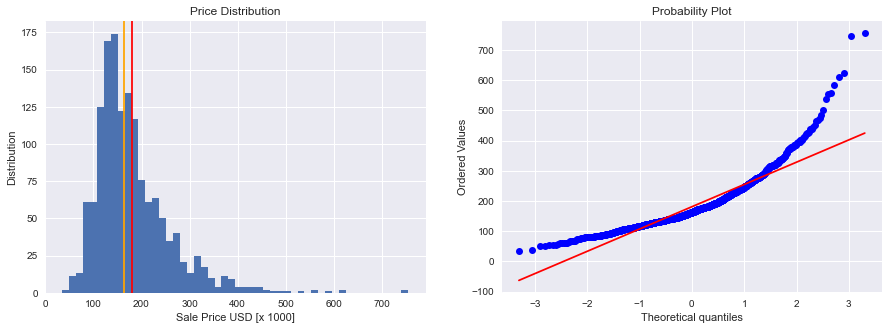

In [39]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.hist(train.SalePrice, bins=50)
plt.axvline(train.SalePrice.mean(), color='red')
plt.axvline(train.SalePrice.median(), color='orange')
plt.title('Price Distribution')
plt.xlabel('Sale Price USD [х 1000]')
plt.ylabel('Distribution')

plt.subplot(1,2,2)
stats.probplot(train['SalePrice'], plot=plt)

plt.show()

От описанието и хистограмата на променливата "Цена", се вижда, че 75% от стойностите на имотите са под 214хил, което ще създаде проблем при предвижданията.
Ще приложим log transformation, така че грешките при прогнозиране на скъпи къщи и евтини къщи да повлияят еднакво на резултата. 

In [40]:
log_prices = np.log1p(train.SalePrice)

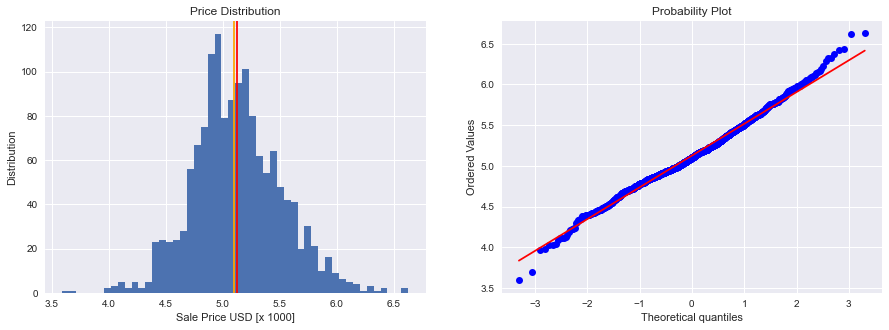

In [41]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.hist(log_prices, bins=50)
plt.axvline(log_prices.mean(), color='red')
plt.axvline(log_prices.median(), color='orange')
plt.title('Price Distribution')
plt.xlabel('Sale Price USD [х 1000]')
plt.ylabel('Distribution')

plt.subplot(1,2,2)
stats.probplot(log_prices, plot=plt)

plt.show()

От диаграмите в анализа на цифровите променливи се забелязва, че голяма част от тях са със сходно разпределение. Забелязва се характерната фуниевидна форма - хетероскедастик шейп. Наличието на хетероскедастичност е основен проблем при регресионния анализ. Познати са редица методи за корекция на това явление, но за целите на настоящия проект, ще подходим по същия начин като при зависимата променлива и ще приложим логаритмична трансформация както на зависимата променлива, така и на всички променливи, които са със скю > 0,5. Този филтър се налага, тъй като прилагането на трансформацията върху данни с по-малко изкривяване, може да доведе до обратния ефект.

In [42]:
skewness = train.select_dtypes(exclude='object').skew()
skewed_features = skewness[skewness>0.5]

train_log = train.copy()
for df in [train_log]:
    for col in skewed_features.index:
        df[col] = np.log1p(df[col])

### 3. Подготовка и разделяне на данните на сетове за трениране и тестване

In [43]:
train_log.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolArea,Fence,SaleType,SaleCondition,SalePrice
0,60,RL,4.189655,9.042040,Not available,Reg,Lvl,Inside,Gtl,CollgCr,...,Y,0.000000,4.127134,0.000000,0.0,0.0,Not available,WD,Normal,5.344724
1,20,RL,4.394449,9.169623,Not available,Reg,Lvl,FR2,Gtl,Veenker,...,Y,5.700444,0.000000,0.000000,0.0,0.0,Not available,WD,Normal,5.206750
2,60,RL,4.234107,9.328212,Not available,IR1,Lvl,Inside,Gtl,CollgCr,...,Y,0.000000,3.761200,0.000000,0.0,0.0,Not available,WD,Normal,5.413876
3,70,RL,4.110874,9.164401,Not available,IR1,Lvl,Corner,Gtl,Crawfor,...,Y,0.000000,3.583519,5.609472,0.0,0.0,Not available,WD,Abnorml,4.948760
4,60,RL,4.442651,9.565284,Not available,IR1,Lvl,FR2,Gtl,NoRidge,...,Y,5.262690,4.442651,0.000000,0.0,0.0,Not available,WD,Normal,5.525453


In [44]:
train_log.shape

(1454, 49)

Разделям данните на фючърси и таргет

In [45]:
train_features = train_log.drop('SalePrice', axis=1)
train_target = train_log['SalePrice']

In [46]:
train_features.shape, train_target.shape

((1454, 48), (1454,))

Задавам бинарни стойности на категорийните променливи. Преценям, че скалиране на данните не е необходимо.

In [47]:
train_features= pd.get_dummies(train_features)

In [48]:
 train_features

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,GrLivArea,BsmtFullBath,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.189655,9.042040,7,1.791759,2003,2003,5.283204,6.753438,7.444833,0.693147,...,0,0,0,1,0,0,0,0,1,0
1,4.394449,9.169623,6,2.197225,1976,1976,0.000000,7.141245,7.141245,0.000000,...,0,0,0,1,0,0,0,0,1,0
2,4.234107,9.328212,7,1.791759,2001,2002,5.093750,6.825460,7.488294,0.693147,...,0,0,0,1,0,0,0,0,1,0
3,4.110874,9.164401,7,1.791759,1915,1970,0.000000,6.629363,7.448916,0.693147,...,0,0,0,1,1,0,0,0,0,0
4,4.442651,9.565284,8,1.791759,2000,2000,5.860786,7.044033,7.695758,0.693147,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,4.143135,8.976894,6,1.791759,1999,2000,0.000000,6.860664,7.407318,0.000000,...,0,0,0,1,0,0,0,0,1,0
1456,4.454347,9.486152,6,1.945910,1978,1988,4.787492,7.341484,7.637234,0.693147,...,0,0,0,1,0,0,0,0,1,0
1457,4.204693,9.109746,7,2.302585,1941,2006,0.000000,7.050123,7.758333,0.000000,...,0,0,0,1,0,0,0,0,1,0
1458,4.234107,9.181735,5,1.945910,1950,1996,0.000000,6.983790,6.983790,0.693147,...,0,0,0,1,0,0,0,0,1,0


In [49]:
train_features_set, test_features_set, train_target_set, test_target_set = train_test_split(
    train_features, train_target, train_size = 0.7, random_state=30)

In [50]:
train_features_set.shape, train_target_set.shape, 

((1017, 214), (1017,))

In [51]:
test_features_set.shape, test_target_set.shape

((437, 214), (437,))

In [52]:
k_fold = KFold(n_splits=5)
k_fold_train_splits = list(k_fold.split(train_features_set, train_target_set))

### 4. Създаване на модели и тяхното оценяване


* Linear Regression - Линейната регресия е един от най-популярни алгоритми в машинното обучение, тъй като е лесна и ясна за разбиране. В този проект ще я използваме за прогнозиране на цените на жилища, за да намерим възможно най-добрата линия, която следва тренировъчния ни сет, след което ще прогнозираме цена на имота от тестовия набор.
* Регресията на Lasso Lars е една от техникитe за намаляване на сложността на модела и предотвратяване прекалено следване на данните. Параметрите на регуляризация могат да бъдат контролирани и по този начин да се постигне по-точна оценка на цените на жилищата.
* Ridge
* RANSAC - 
* DecisionTree - Дърво на решенията
* GBR - Регресията за повишаване на градиента (GBR) е машинно обучение, което може да се използва за изграждане на прогнозен модел за регресионни проблеми като прогнозира цените на жилищата под формата на ансамбъл от слаби прогнози модели. GBR повтаря многократно моделите и засилва прогнозата на моделите със слаби прогнози и ги прави по -добъри. Основната цел е да намалим до минимум нашата Loss функция. 
* LinearSVR
* SVR 

### Линейна регресия

In [53]:
params = {
    'normalize':[True, False],
    'fit_intercept': [True, False]
}
grid_search_lin_reg = GridSearchCV(estimator=LinearRegression(), param_grid=params, cv=k_fold_train_splits)
grid_search_lin_reg.fit(train_features_set, train_target_set)
pd.DataFrame(grid_search_lin_reg.cv_results_).T

,0,1,2,3
mean_fit_time,0.0148122,0.0149823,0.0138123,0.0138596
std_fit_time,0.000731691,0.00237421,0.000704718,0.000639211
mean_score_time,0.00338392,0.00323033,0.00301986,0.00270014
std_score_time,0.00050228,0.000390813,0.000633743,0.0003988
param_fit_intercept,True,True,False,False
param_normalize,True,False,True,False
params,"{'fit_intercept': True, 'normalize': True}","{'fit_intercept': True, 'normalize': False}","{'fit_intercept': False, 'normalize': True}","{'fit_intercept': False, 'normalize': False}"
split0_test_score,-3.14082e+20,-2.26739e+16,0.853549,0.853549
split1_test_score,-5.24815e+20,-1.57448e+16,0.925747,0.925747
split2_test_score,-2.41625e+19,-1.03783e+17,0.912401,0.912401


In [54]:
evaluate(grid_search_lin_reg.best_estimator_, train_features_set, train_target_set, test_features_set, test_target_set)

TRAIN Sets results:

R2 Score: 0.9426862549064822
Mean Absolute Error: 0.06604760881395677
Mean Squared Error: 0.008368844164910282
Root Mean Squared Error: 0.09148138698615299

**************************************************
TEST Sets results:

R2 Score: 0.9171080068812372
Mean Absolute Error: 0.08115558972182343
Mean Squared Error: 0.01400309087402156
Root Mean Squared Error: 0.11833465626781345


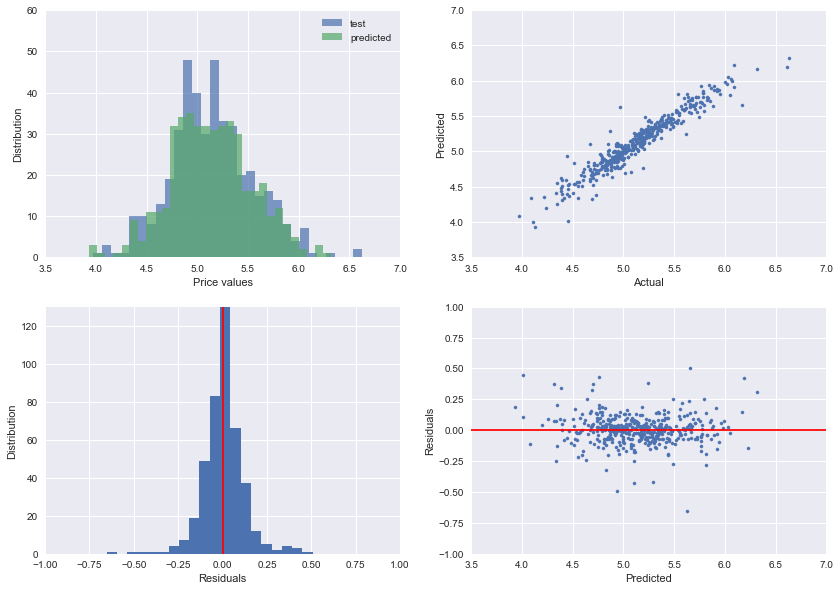

In [55]:
y_predict = grid_search_lin_reg.best_estimator_.predict(test_features_set)
plot(test_target_set, y_predict)

### GRIDSearch с Lasso

In [56]:
params = {
    'alpha': [0.0002, 0.0003, 0.0004, 0.0005, 0.0006],
#     'fit_intercept': [True, False],
    'max_iter': [100000, 200000],
}
grid_search_lasso = GridSearchCV(estimator=Lasso(), param_grid=params, cv=k_fold_train_splits)
grid_search_lasso.fit(train_features_set, train_target_set)
pd.DataFrame(grid_search_lasso.cv_results_).T

,0,1,2,3,4,5,6,7,8,9
mean_fit_time,0.0197578,0.0197462,0.0187089,0.0189149,0.0139764,0.0140192,0.0123793,0.0138664,0.0112587,0.0113995
std_fit_time,0.00452535,0.00233552,0.00177135,0.000664196,0.00186326,0.00271506,0.0018031,0.00164945,0.00146787,0.000799869
mean_score_time,0.00279989,0.0028059,0.00260043,0.00277123,0.00240021,0.0027986,0.00263596,0.00344653,0.00240183,0.00276837
std_score_time,0.000400019,0.000756298,0.000490175,0.00030234,0.000490038,0.000399511,0.000483535,0.000394681,0.000492226,0.00038911
param_alpha,0.0002,0.0002,0.0003,0.0003,0.0004,0.0004,0.0005,0.0005,0.0006,0.0006
param_max_iter,100000,200000,100000,200000,100000,200000,100000,200000,100000,200000
params,"{'alpha': 0.0002, 'max_iter': 100000}","{'alpha': 0.0002, 'max_iter': 200000}","{'alpha': 0.0003, 'max_iter': 100000}","{'alpha': 0.0003, 'max_iter': 200000}","{'alpha': 0.0004, 'max_iter': 100000}","{'alpha': 0.0004, 'max_iter': 200000}","{'alpha': 0.0005, 'max_iter': 100000}","{'alpha': 0.0005, 'max_iter': 200000}","{'alpha': 0.0006, 'max_iter': 100000}","{'alpha': 0.0006, 'max_iter': 200000}"
split0_test_score,0.887611,0.887611,0.887336,0.887336,0.887253,0.887253,0.886825,0.886825,0.886759,0.886759
split1_test_score,0.934402,0.934402,0.935403,0.935403,0.935995,0.935995,0.9363,0.9363,0.936061,0.936061
split2_test_score,0.9238,0.9238,0.922583,0.922583,0.921448,0.921448,0.9211,0.9211,0.920803,0.920803


In [57]:
evaluate(grid_search_lasso.best_estimator_, train_features_set, train_target_set, test_features_set, test_target_set)

TRAIN Sets results:

R2 Score: 0.9387634868830372
Mean Absolute Error: 0.06819816078618063
Mean Squared Error: 0.008941639298603563
Root Mean Squared Error: 0.09456024163782346

**************************************************
TEST Sets results:

R2 Score: 0.9274745345120644
Mean Absolute Error: 0.07775253447480196
Mean Squared Error: 0.012251855042901558
Root Mean Squared Error: 0.11068809801826734


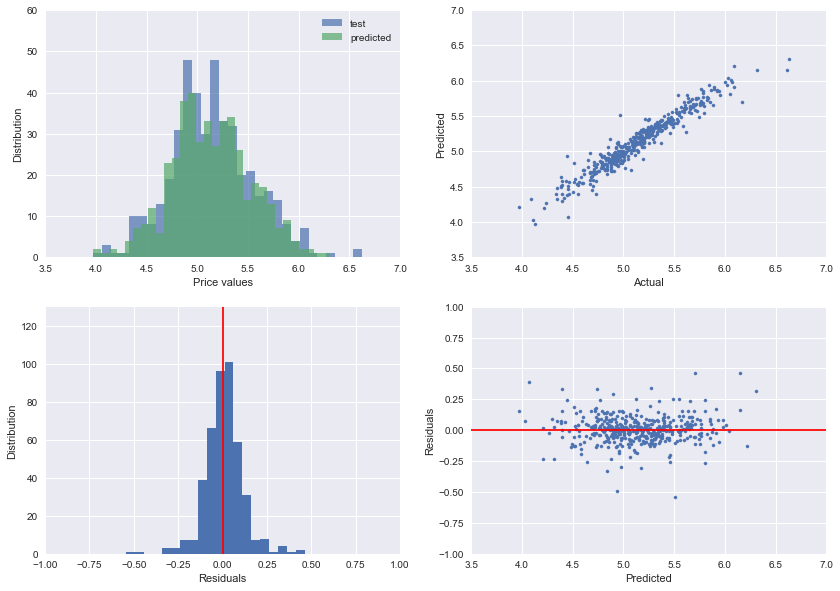

In [58]:
y_predicted_lasso = grid_search_lasso.best_estimator_.predict(test_features_set)
plot(test_target_set, y_predicted_lasso)

In [59]:
coef_df = pd.DataFrame(zip(test_features_set.columns.T, grid_search_lasso.best_estimator_.coef_ ), columns=['feature', 'coefficient'])
coef_df[abs(coef_df.coefficient) > 0].sort_values('coefficient', ascending=False).head(10)

,feature,coefficient
8,GrLivArea,0.436425
3,OverallCond,0.301381
158,BsmtQual_Not available,0.230975
82,Neighborhood_StoneBr,0.144745
116,Exterior1st_BrkFace,0.092782
66,Neighborhood_Crawfor,0.091830
1,LotArea,0.088641
76,Neighborhood_NridgHt,0.083555
9,BsmtFullBath,0.081528
75,Neighborhood_NoRidge,0.073462


In [223]:
ridge_model = Ridge(alpha=2)
ridge_model.fit(train_features_set, train_target_set)

Ridge(alpha=2)

In [224]:
ridge_model.score(train_features_set, train_target_set)

0.9402342836244028

In [225]:
ridge_model.score(test_features_set, test_target_set)

0.9270765943805989

### Grid Search Ridge

In [229]:
params = {
    'alpha': [1, 2, 3, 4, 5],
}
grid_search_ridge = GridSearchCV(estimator=Ridge(), param_grid=params, cv=k_fold_train_splits)
grid_search_ridge.fit(train_features_set, train_target_set)
pd.DataFrame(grid_search_ridge.cv_results_).T

,0,1,2,3,4
mean_fit_time,0.0101269,0.00700088,0.00739894,0.00821567,0.00661974
std_fit_time,0.00466699,0.000833888,0.00241741,0.0014937,0.00138651
mean_score_time,0.0034287,0.0026011,0.00359917,0.00260477,0.00326734
std_score_time,0.000751242,0.000491404,0.00135641,0.000485985,0.000389859
param_alpha,1,2,3,4,5
params,{'alpha': 1},{'alpha': 2},{'alpha': 3},{'alpha': 4},{'alpha': 5}
split0_test_score,0.87925,0.882471,0.883048,0.882755,0.88209
split1_test_score,0.931547,0.93238,0.932499,0.932344,0.932054
split2_test_score,0.922561,0.924687,0.925159,0.925015,0.924579
split3_test_score,0.914247,0.914519,0.913695,0.912483,0.91113


In [230]:
evaluate(grid_search_ridge.best_estimator_, train_features_set, train_target_set, test_features_set, test_target_set)

TRAIN Sets results:

R2 Score: 0.9402342836244028
Mean Absolute Error: 0.06703747717430611
Mean Squared Error: 0.008726876352879777
Root Mean Squared Error: 0.09341775180810004

**************************************************
TEST Sets results:

R2 Score: 0.9270765943805989
Mean Absolute Error: 0.07816694853376298
Mean Squared Error: 0.012319079772500581
Root Mean Squared Error: 0.11099134998954009


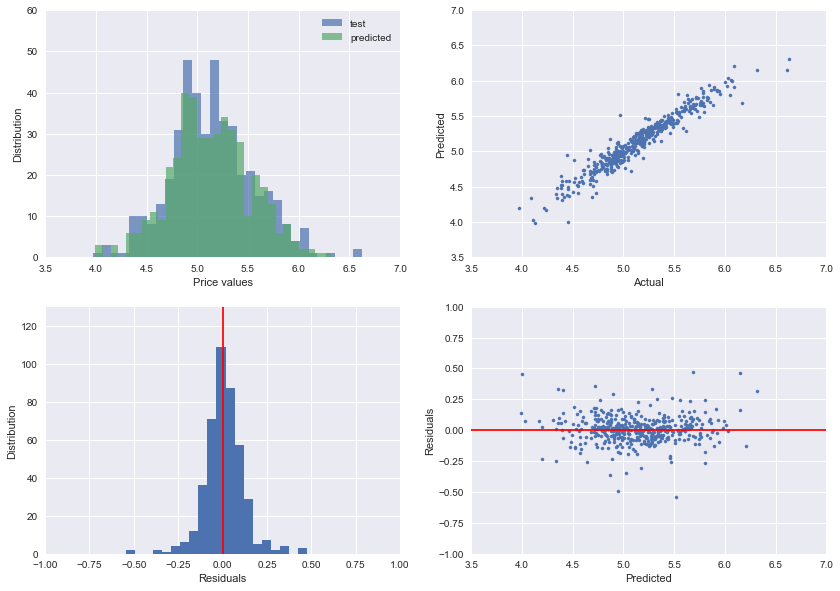

In [231]:
y_predicted_ridge = grid_search_ridge.best_estimator_.predict(test_features_set)
plot(test_target_set, y_predicted_elastic)

### RANSAC

In [63]:
params = {
#     'min_samples': [300, 350, 400, 420, 450, 500]
    'min_samples': [0.94, 0.95, 0.96, 0.97, 0.99],
#     'stop_score':[0.97]
}
grid_search_ransac = GridSearchCV(estimator=RANSACRegressor(base_estimator=grid_search_lasso.best_estimator_, random_state=1), 
                                  param_grid=params, 
                                  cv=k_fold_train_splits)
grid_search_ransac.fit(train_features_set, train_target_set)
pd.DataFrame(grid_search_ransac.cv_results_).T

,0,1,2,3,4
mean_fit_time,1.70806,1.84887,1.93432,1.90409,1.91801
std_fit_time,0.220417,0.238873,0.306045,0.295701,0.37757
mean_score_time,0.00368986,0.00383973,0.00320029,0.00312614,0.00358496
std_score_time,0.00039903,0.000952919,0.000400782,0.000409527,0.000826604
param_min_samples,0.94,0.95,0.96,0.97,0.99
params,{'min_samples': 0.94},{'min_samples': 0.95},{'min_samples': 0.96},{'min_samples': 0.97},{'min_samples': 0.99}
split0_test_score,0.889659,0.889659,0.889659,0.889659,0.888233
split1_test_score,0.935521,0.935374,0.935634,0.93561,0.935634
split2_test_score,0.92572,0.92572,0.92572,0.925428,0.924604
split3_test_score,0.911777,0.912368,0.911678,0.911011,0.90555


In [64]:
evaluate(grid_search_ransac.best_estimator_, train_features_set, train_target_set, test_features_set, test_target_set)

TRAIN Sets results:

R2 Score: 0.9348557632621707
Mean Absolute Error: 0.06751368653394715
Mean Squared Error: 0.009512237677216066
Root Mean Squared Error: 0.0975307012033445

**************************************************
TEST Sets results:

R2 Score: 0.9316963774726023
Mean Absolute Error: 0.07637926616582388
Mean Squared Error: 0.011538651651259656
Root Mean Squared Error: 0.10741811602918595


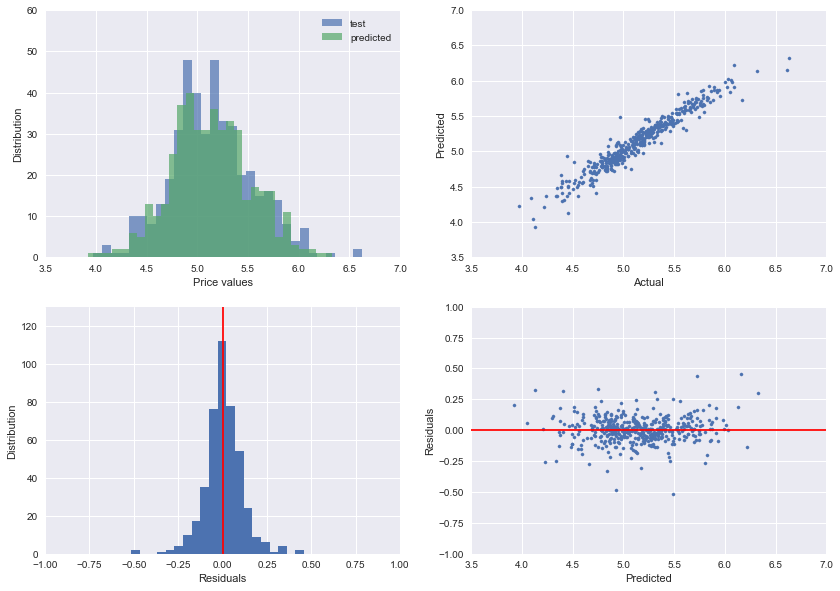

In [65]:
y_predicted_ransac = grid_search_ransac.best_estimator_.predict(test_features_set)
plot(test_target_set, y_predicted_ransac)

In [66]:
inliers = train_features_set[grid_search_ransac.best_estimator_.inlier_mask_]
outliers = train_features_set[~grid_search_ransac.best_estimator_.inlier_mask_]
len(inliers), len(outliers)

(998, 19)

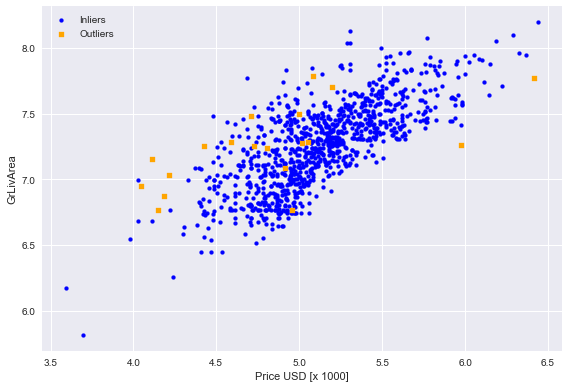

In [67]:
plt.scatter(
    train_target_set[inliers.index], 
    train_features_set.GrLivArea[inliers.index], 
    c='blue', 
    marker='o', 
    s= 15, 
    label='Inliers'
)
plt.scatter(
    train_target_set[outliers.index], 
    train_features_set.GrLivArea[outliers.index], 
    c='orange', 
    marker='s', 
    s=25, 
    label='Outliers'
)

plt.xlabel('Price USD [x 1000]')
plt.ylabel('GrLivArea')
plt.legend(loc='upper left')
 
plt.tight_layout()
plt.show()

In [129]:
grid_search_ransac.best_estimator_ = grid_search_ransac.best_estimator_.fit(inliers, train_target_set[inliers.index])

In [130]:
evaluate(grid_search_ransac.best_estimator_, inliers, train_target_set[inliers.index], test_features_set, test_target_set)

TRAIN Sets results:

R2 Score: 0.955477792761751
Mean Absolute Error: 0.061339595736891156
Mean Squared Error: 0.006244448865939423
Root Mean Squared Error: 0.07902182525061936

**************************************************
TEST Sets results:

R2 Score: 0.9321969805646199
Mean Absolute Error: 0.07612282484665908
Mean Squared Error: 0.01145408388632131
Root Mean Squared Error: 0.10702375384147815


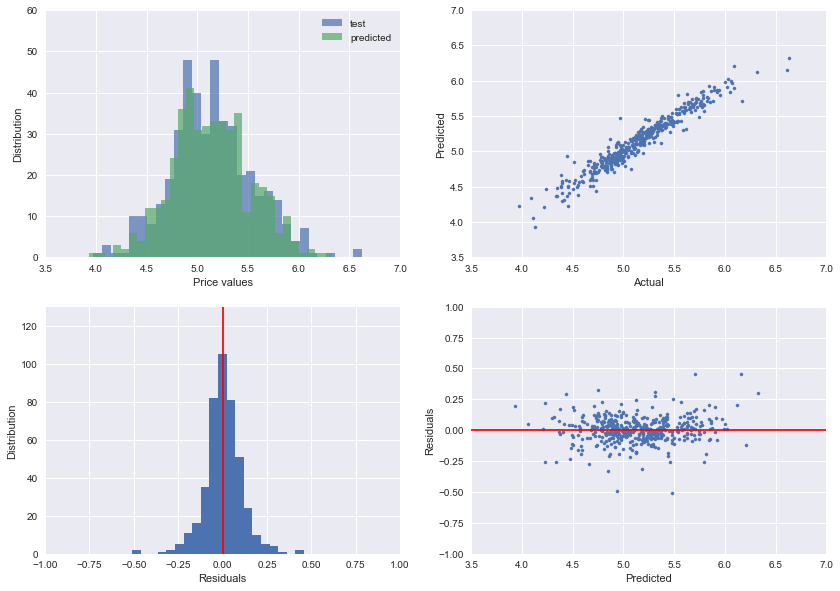

In [131]:
y_predicted_ransac = grid_search_ransac.best_estimator_.predict(test_features_set)
plot(test_target_set, y_predicted_ransac)

### Grid Search Decision Tree

In [71]:
params = {
    'max_depth': [5, 6, 7, 8, 9, 10, 11],
    'max_leaf_nodes': [30,40, 50, 60, 70, 80],
    'min_samples_leaf': [2,3, 4, 5, 7, 10],
    'max_features': [50,70,80,100]   
}
grid_search_DTR = GridSearchCV(estimator=DecisionTreeRegressor(), param_grid=params, cv=k_fold_train_splits)
grid_search_DTR.fit(train_features_set, train_target_set)
pd.DataFrame(grid_search_DTR.cv_results_).T

,0,1,2,3,4,5,6,7,8,9,...,998,999,1000,1001,1002,1003,1004,1005,1006,1007
mean_fit_time,0.00613818,0.00654178,0.00664759,0.00649133,0.00674047,0.00664802,0.00638757,0.00624881,0.00572128,0.00540366,...,0.00806723,0.00800476,0.00798602,0.00752974,0.00882549,0.00858788,0.00821147,0.00800228,0.00800467,0.00780454
std_fit_time,0.0010009,0.00100486,0.000800368,0.000759585,0.00081216,0.000536235,0.00047567,0.000342802,0.000629987,0.000504455,...,9.14387e-05,1.90735e-07,3.7773e-05,0.000437141,0.00041253,0.000518417,0.00039682,5.4835e-05,3.37175e-07,0.0003999
mean_score_time,0.00310731,0.00259633,0.00299153,0.00308714,0.0024632,0.00220642,0.00280762,0.00260043,0.00197811,0.00198069,...,0.00230737,0.00240011,0.00221763,0.00229502,0.00237885,0.00241756,0.00220041,0.00238528,0.00220017,0.00240026
std_score_time,0.000786064,0.000514721,0.000637541,0.000871793,0.000534588,0.000415192,0.0006961,0.000800371,3.34913e-05,3.97136e-05,...,0.000355222,0.000490213,0.000393168,0.000426381,0.000465199,0.000479674,0.000400043,0.000505198,0.000400043,0.000489804
param_max_depth,5,5,5,5,5,5,5,5,5,5,...,11,11,11,11,11,11,11,11,11,11
param_max_features,50,50,50,50,50,50,50,50,50,50,...,100,100,100,100,100,100,100,100,100,100
param_max_leaf_nodes,30,30,30,30,30,30,40,40,40,40,...,70,70,70,70,80,80,80,80,80,80
param_min_samples_leaf,2,3,4,5,7,10,2,3,4,5,...,4,5,7,10,2,3,4,5,7,10
params,"{'max_depth': 5, 'max_features': 50, 'max_leaf...","{'max_depth': 5, 'max_features': 50, 'max_leaf...","{'max_depth': 5, 'max_features': 50, 'max_leaf...","{'max_depth': 5, 'max_features': 50, 'max_leaf...","{'max_depth': 5, 'max_features': 50, 'max_leaf...","{'max_depth': 5, 'max_features': 50, 'max_leaf...","{'max_depth': 5, 'max_features': 50, 'max_leaf...","{'max_depth': 5, 'max_features': 50, 'max_leaf...","{'max_depth': 5, 'max_features': 50, 'max_leaf...","{'max_depth': 5, 'max_features': 50, 'max_leaf...",...,"{'max_depth': 11, 'max_features': 100, 'max_le...","{'max_depth': 11, 'max_features': 100, 'max_le...","{'max_depth': 11, 'max_features': 100, 'max_le...","{'max_depth': 11, 'max_features': 100, 'max_le...","{'max_depth': 11, 'max_features': 100, 'max_le...","{'max_depth': 11, 'max_features': 100, 'max_le...","{'max_depth': 11, 'max_features': 100, 'max_le...","{'max_depth': 11, 'max_features': 100, 'max_le...","{'max_depth': 11, 'max_features': 100, 'max_le...","{'max_depth': 11, 'max_features': 100, 'max_le..."
split0_test_score,0.616951,0.544245,0.70851,0.696533,0.62269,0.688081,0.641774,0.630064,0.605575,0.655148,...,0.682226,0.71074,0.721369,0.697815,0.599701,0.713509,0.682322,0.709047,0.709545,0.683766


In [72]:
evaluate(grid_search_DTR.best_estimator_, train_features_set, train_target_set, test_features_set, test_target_set)

TRAIN Sets results:

R2 Score: 0.884408316121514
Mean Absolute Error: 0.09851069454198813
Mean Squared Error: 0.016878478060719706
Root Mean Squared Error: 0.12991719693989592

**************************************************
TEST Sets results:

R2 Score: 0.797751500838626
Mean Absolute Error: 0.1408544458313359
Mean Squared Error: 0.03416619635184206
Root Mean Squared Error: 0.18484100289665725


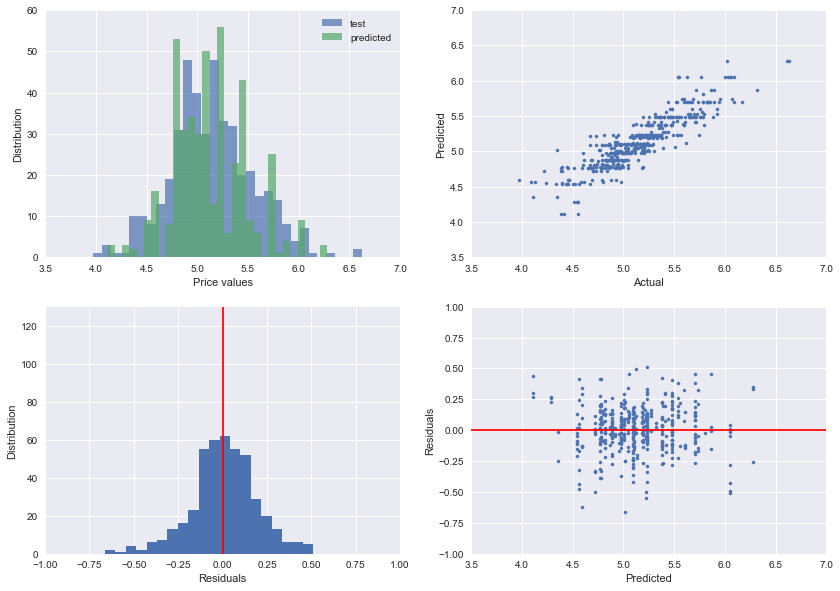

In [73]:
y_predicted_grid_dtr = grid_search_DTR.best_estimator_.predict(test_features_set)
plot(test_target_set, y_predicted_grid_dtr)

### GBR - Gradient Boosting Regressor

In [74]:
params = {
    'loss': ['ls', 'lad', 'huber'],
    'n_estimators': [200, 250, 300, 350, 400],
    'criterion': ['mse'],
    'subsample': [0.3, 0.4, 0.5, 0.6, 0.7]
}
grid_search_gbr = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=params, cv=k_fold_train_splits)
grid_search_gbr.fit(train_features_set, train_target_set)
pd.DataFrame(grid_search_gbr.cv_results_).T

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
mean_fit_time,0.264047,0.318981,0.386551,0.450945,0.513173,0.32041,0.401614,0.490846,0.565431,0.641186,...,0.830397,0.924459,1.0291,1.16533,1.26452,0.906864,1.04233,1.17142,1.29164,1.43897
std_fit_time,0.00382073,0.00180093,0.00487483,0.00314654,0.0059191,0.00606842,0.00913442,0.0103226,0.0132453,0.00636775,...,0.0442578,0.00660481,0.00671387,0.0117385,0.0148154,0.00770798,0.00725312,0.014991,0.0106667,0.0428597
mean_score_time,0.00299907,0.00300021,0.00300136,0.00321398,0.00320396,0.00319157,0.00361214,0.00344539,0.00325541,0.00380116,...,0.00404577,0.00320859,0.00378141,0.00387516,0.00378671,0.00418458,0.00398841,0.00380635,0.003619,0.00371065
std_score_time,1.23389e-05,1.78416e-07,5.90701e-06,0.000399903,0.000403837,0.000403385,0.000480535,0.00055035,0.000350116,0.00041123,...,0.000702313,0.000397507,0.000749168,0.000226347,0.000393816,0.000392203,3.11421e-05,0.000403523,0.000505923,0.000386365
param_criterion,mse,mse,mse,mse,mse,mse,mse,mse,mse,mse,...,mse,mse,mse,mse,mse,mse,mse,mse,mse,mse
param_loss,ls,ls,ls,ls,ls,ls,ls,ls,ls,ls,...,huber,huber,huber,huber,huber,huber,huber,huber,huber,huber
param_n_estimators,200,200,200,200,200,250,250,250,250,250,...,350,350,350,350,350,400,400,400,400,400
param_subsample,0.3,0.4,0.5,0.6,0.7,0.3,0.4,0.5,0.6,0.7,...,0.3,0.4,0.5,0.6,0.7,0.3,0.4,0.5,0.6,0.7
params,"{'criterion': 'mse', 'loss': 'ls', 'n_estimato...","{'criterion': 'mse', 'loss': 'ls', 'n_estimato...","{'criterion': 'mse', 'loss': 'ls', 'n_estimato...","{'criterion': 'mse', 'loss': 'ls', 'n_estimato...","{'criterion': 'mse', 'loss': 'ls', 'n_estimato...","{'criterion': 'mse', 'loss': 'ls', 'n_estimato...","{'criterion': 'mse', 'loss': 'ls', 'n_estimato...","{'criterion': 'mse', 'loss': 'ls', 'n_estimato...","{'criterion': 'mse', 'loss': 'ls', 'n_estimato...","{'criterion': 'mse', 'loss': 'ls', 'n_estimato...",...,"{'criterion': 'mse', 'loss': 'huber', 'n_estim...","{'criterion': 'mse', 'loss': 'huber', 'n_estim...","{'criterion': 'mse', 'loss': 'huber', 'n_estim...","{'criterion': 'mse', 'loss': 'huber', 'n_estim...","{'criterion': 'mse', 'loss': 'huber', 'n_estim...","{'criterion': 'mse', 'loss': 'huber', 'n_estim...","{'criterion': 'mse', 'loss': 'huber', 'n_estim...","{'criterion': 'mse', 'loss': 'huber', 'n_estim...","{'criterion': 'mse', 'loss': 'huber', 'n_estim...","{'criterion': 'mse', 'loss': 'huber', 'n_estim..."
split0_test_score,0.867963,0.876922,0.879214,0.880297,0.879431,0.870842,0.874115,0.86696,0.877797,0.872779,...,0.889082,0.877661,0.892323,0.88999,0.873929,0.875796,0.878757,0.889639,0.884036,0.871795


In [75]:
evaluate(grid_search_gbr.best_estimator_, train_features_set, train_target_set, test_features_set, test_target_set)

TRAIN Sets results:

R2 Score: 0.9741872517115205
Mean Absolute Error: 0.03844688353360083
Mean Squared Error: 0.0037691284619746773
Root Mean Squared Error: 0.06139322814427237

**************************************************
TEST Sets results:

R2 Score: 0.9286421268678988
Mean Absolute Error: 0.0758885013791778
Mean Squared Error: 0.012054611603005782
Root Mean Squared Error: 0.10979349526727794


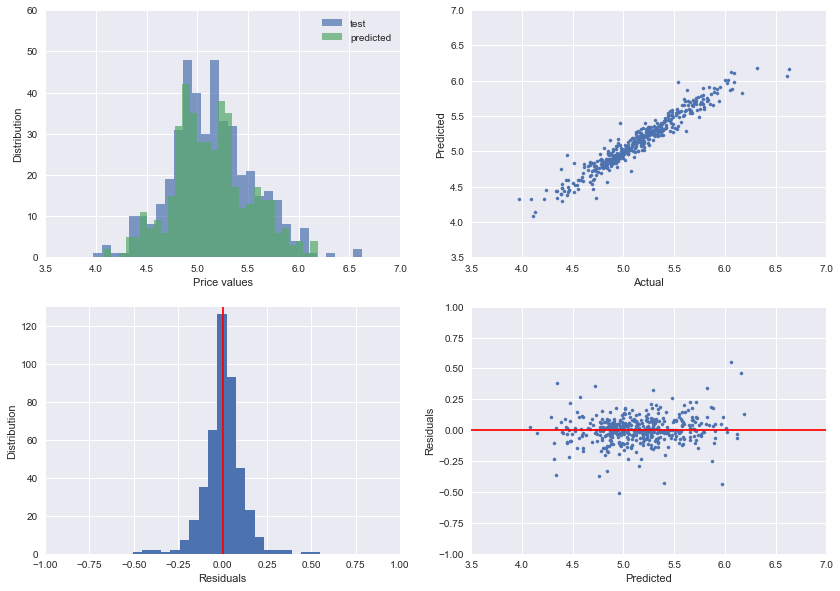

In [76]:
y_predicted_gbr = grid_search_gbr.best_estimator_.predict(test_features_set)
plot(test_target_set, y_predicted_gbr)

In [77]:
feature_importance_grid_gbr = pd.DataFrame(zip(train_features_set.columns, grid_search_gbr.best_estimator_.feature_importances_), columns=['feature', 'value'])

In [78]:
feature_importance_grid_gbr.sort_values(by='value', ascending=False).head(10)

,feature,value
2,OverallQual,0.408010
8,GrLivArea,0.170272
4,YearBuilt,0.091035
7,TotalBsmtSF,0.087230
15,GarageCars,0.041229
1,LotArea,0.023763
5,YearRemodAdd,0.018399
3,OverallCond,0.016764
14,Fireplaces,0.015536
17,OpenPorchSF,0.011164


### Linear SVR

In [182]:
params = {
    'kernel': ['linear', 'poly', 'rbf'],
    'degree': [2, 3],
#     'max_iter': [1e6]
}
grid_search_linear_svr = GridSearchCV(estimator=SVR(), param_grid=params, cv=k_fold_train_splits)
grid_search_linear_svr.fit(train_features_set, train_target_set)

GridSearchCV(cv=[(array([ 204,  205,  206,  207,  208,  209,  210,  211,  212,  213,  214,
        215,  216,  217,  218,  219,  220,  221,  222,  223,  224,  225,
        226,  227,  228,  229,  230,  231,  232,  233,  234,  235,  236,
        237,  238,  239,  240,  241,  242,  243,  244,  245,  246,  247,
        248,  249,  250,  251,  252,  253,  254,  255,  256,  257,  258,
        259,  260,  261,  262,  263,  264,  265,  266,  267,  268,  269,
        270,  271,  272,  273,  274,  275,  276,  277,  278,  279,  280,
        281,  282,  283,  284,  2...
        946,  947,  948,  949,  950,  951,  952,  953,  954,  955,  956,
        957,  958,  959,  960,  961,  962,  963,  964,  965,  966,  967,
        968,  969,  970,  971,  972,  973,  974,  975,  976,  977,  978,
        979,  980,  981,  982,  983,  984,  985,  986,  987,  988,  989,
        990,  991,  992,  993,  994,  995,  996,  997,  998,  999, 1000,
       1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 10

In [183]:
grid_search_linear_svr.best_estimator_.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'poly',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [184]:
evaluate(grid_search_linear_svr.best_estimator_, train_features_set, train_target_set, test_features_set, test_target_set)

TRAIN Sets results:

R2 Score: 0.3926390043071666
Mean Absolute Error: 0.22391927511534904
Mean Squared Error: 0.08868569863135585
Root Mean Squared Error: 0.29780144162068095

**************************************************
TEST Sets results:

R2 Score: 0.3551782672477789
Mean Absolute Error: 0.24208581502324483
Mean Squared Error: 0.10893087476297564
Root Mean Squared Error: 0.33004677662867066


In [185]:
y_predicted_linnear_svr = grid_search_linear_svr.best_estimator_.predict(test_features_set)

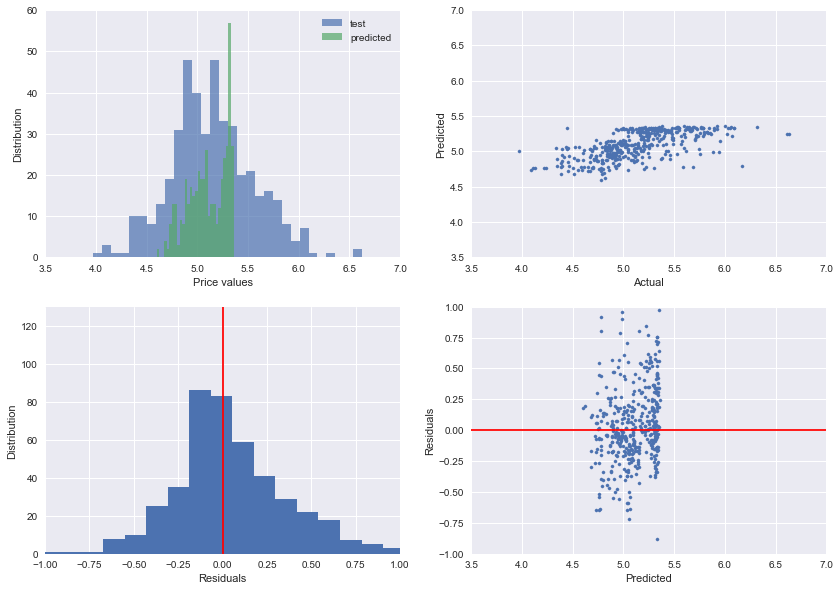

In [186]:
plot(test_target_set, y_predicted_linnear_svr)

### 5. Резултати

In [232]:
all_models_dict = {
    'Linear Regression': grid_search_lin_reg.best_estimator_, 
    'Lasso': grid_search_lasso.best_estimator_,
    'Ridge': grid_search_ridge.best_estimator_,
    'RANSAC Regressor': grid_search_ransac.best_estimator_,
    'Decision Tree Regressor': grid_search_DTR.best_estimator_, 
    'Gradient Boosting Regressor': grid_search_gbr.best_estimator_,
             }

In [233]:
results_df = pd.DataFrame(columns=['Model','R2 - train', 'R2 - test','MAE - test', 'MSE - test', 'RMSE - test'])
for name, model in all_models_dict.items():
    result = pd.DataFrame(
        data=[[name, *final_evaluation(model, train_features_set, train_target_set, test_features_set, test_target_set)]], 
        columns=['Model', 'R2 - train', 'R2 - test','MAE - test', 'MSE - test', 'RMSE - test']
    )
    results_df = results_df.append(result, ignore_index=True) 
    
results_df

,Model,R2 - train,R2 - test,MAE - test,MSE - test,RMSE - test
0,Linear Regression,0.942686,0.917108,15.458353,773.846191,27.818091
1,Lasso,0.938449,0.924845,15.023807,752.811370,27.437408
2,Ridge,0.940234,0.927077,14.986830,742.021895,27.240079
3,RANSAC Regressor,0.933069,0.932197,14.619567,711.358272,26.671301
4,Decision Tree Regressor,0.884408,0.797752,26.821366,1670.026466,40.865957
5,Gradient Boosting Regressor,0.974187,0.928642,15.057649,867.317693,29.450258


### Избор на най-добрия модел и анализ на резултатите от него

Разглеждаме подробно резултатите от най-добрия ни модел. За нуждите на проекта, предмет на интерес е не стойността на остатъците, а техният процент от тестовият сет като цяло и за всеки единичен запис.

In [175]:
# Извеждаме моделът с най-добър резултат и неговите прогнози
best_model = results_df.Model[results_df['R2 - test'] == results_df['R2 - test'].max()].values
best_prediction = all_models_dict[best_model[0]].predict(test_features_set)
best_model

array(['RANSAC Regressor'], dtype=object)

In [176]:
# Създаваме таблица с резултатите на най-добрия модел
test_prices = np.expm1(test_target_set)
predicted_prices = np.expm1(best_prediction)
residuals = test_prices - predicted_prices
predicted_prices_df = pd.DataFrame({'test_set_index': test_target_set.index,
                                    'test_price': list(test_prices), 
                                    'predicted_price': list(predicted_prices), 
                                    'residuals': list((residuals)), 
                                    'residuals_%': list(((residuals)/test_prices)*100),
                                    'abs_residuals_%': list((abs(residuals)/test_prices)*100)})
predicted_prices_df

,test_set_index,test_price,predicted_price,residuals,resid_%,abs_resid_%
0,1003,136.905,157.717111,-20.812111,-15.201863,15.201863
1,221,200.000,201.660361,-1.660361,-0.830181,0.830181
2,1161,224.000,221.274446,2.725554,1.216765,1.216765
3,835,128.000,132.176327,-4.176327,-3.262756,3.262756
4,1296,155.000,150.762359,4.237641,2.733962,2.733962
...,...,...,...,...,...,...
432,389,426.000,403.970490,22.029510,5.171247,5.171247
433,1339,128.500,124.399086,4.100914,3.191373,3.191373
434,1159,185.000,184.217514,0.782486,0.422966,0.422966
435,747,265.979,201.240775,64.738225,24.339600,24.339600


In [177]:
# Изчисляваме процентът на отклонение в оценяването на пакета от обекти
(predicted_prices_df.test_price.sum()-predicted_prices_df.predicted_price.sum())/predicted_prices_df.predicted_price.sum()*100

1.7244164163722948

In [178]:
# Извеждаме предвижданията, чиито процент остатъци са по-малко или равни на 5%
len(predicted_prices_df[predicted_prices_df['abs_residuals_%'] <= 5])

199

### Изводи
На база на изведените резултати, може да се направят следните изводи:
* Най-добрият модел може да бъде използван за предвиждане на стойността на пакети от недвижими имоти
* Най-добрия модел не може да бъде използван за предвиждане на индивидуални стойности, тъй като вероятността за разлика в проценти, над допустимата за бранша е много висока.

Предвид множеството субективни фактори, влияещи върху взимането на решение за покупка на недвижим имот, считаме, че моделите биха имали по-добър резултат при по-обстоен анализ за селектиране на променливите, техния инженеринг, както и при работа с по-голям обем от данни.

### 6. Ресурси